In [8]:
#Data handling
import numpy as np

import pandas as pd
from sklearn.neighbors import kneighbors_graph
import networkx as nx

#Embedding
#from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#Modelling
from sklearn.mixture import GaussianMixture
import sklearn
from copy import deepcopy


#OT
import ot
from gmmot import *

#Plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


rng = np.random.default_rng(seed=42)
%matplotlib inline

In [9]:
def plot_ellipses(gmm, pts=None, ax=None, title=None):
        if ax is None:
            fig =plt.figure()
            ax = fig.gca()
            

        if pts is not None:
            ax.scatter(pts[:, 0],pts[:, 1],s=1,alpha=0.1) #,c='black')
        else:
            plt.show()
            
        n_classes = gmm.n_components
        colors = sns.color_palette("Set2",n_classes)
        for n, color in enumerate(colors):
            if gmm.covariance_type == "full":
                covariances = gmm.covariances_[n][:2, :2]
            elif gmm.covariance_type == "tied":
                covariances = gmm.covariances_[:2, :2]
            elif gmm.covariance_type == "diag":
                covariances = np.diag(gmm.covariances_[n][:2])
            elif gmm.covariance_type == "spherical":
                covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = mpl.patches.Ellipse(
                gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
            )
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)
            ax.set_aspect("equal", "datalim")

        
        plt.xticks(())
        plt.yticks(())


        if title is not None:
            ax.set_title(title)


def GMM_wasserstein_dist(GMM0,GMM1):
    K0,d = GMM0.means_.shape #currently only for d1 = d2
    K1, _ = GMM1.means_.shape

    pi0=GMM0.weights_
    mu0=GMM0.means_
    S0=GMM0.covariances_

    pi1=GMM1.weights_
    mu1=GMM1.means_
    S1=GMM1.covariances_

    wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
    return dist


def pairwise_GMM_wasserstein_dist(GMMs):
    dist = np.zeros((len(GMMs),len(GMMs)))
    for i,gmm1 in enumerate(GMMs):
        for j,gmm2 in enumerate(GMMs):
            dist[i,j] = GMM_wasserstein_dist(gmm1,gmm2)


    sns.heatmap(dist) #,xticklabels=graph_iter_labels, yticklabels=graph_iter_labels,cmap="crest")

#roation/reflection invariant OT
def inner_GMM__wasserstein_dist(GMM, pts,shape_only=False):
    GMM = deepcopy(GMM)

    pi=GMM.weights_
    mu=GMM.means_
    S =GMM.covariances_
    
    #pts_of_comps = [[]] * len(S)

    comp_of_pts = GMM.predict(pts)
    #print(comp_of_pts)

    aligned_S = np.copy(GMM.covariances_)

    if shape_only:
        
        for component,(mu_,s) in enumerate(zip(mu,S)):   

            #pca = PCA()
            #pca.fit(pts[comp_of_pts==component]-mu_)

            _, _, Vt = np.linalg.svd(pts[comp_of_pts==component]-mu_)

            aligned_S[component]  = np.cov(((pts[comp_of_pts==component]-mu_)@ Vt).T)

            #plt.figure(component+2)
            #v , w = np.linalg.eigh(s)
            #plt.scatter(v,w)

            #plt.scatter(s[:, 0],s[:, 1])
            #plt.scatter(((pts[comp_of_pts==component]-mu_)@ Vt )[:, 0],((pts[comp_of_pts==component]-mu_)@ Vt)[:, 1])

            #aligned_S[component]  = ((s-mu_) @ Vt ) +mu_

            #
            #s = s.reshape(-1, 1) 
            #print(s)                   

            #aligned_S[component] = pca.get_covariance() # sorted_by_order # np.squeeze(pca.fit_transform(s))

            #print(aligned_S[component])

        GMM.covariances_=aligned_S

    #plot_ellipses(GMM, pts)
    #compute pairwise wassersteins dists between gaussians
    dist = np.zeros((len(mu),len(mu)))
    for i,(m0,S0) in enumerate(zip(mu,aligned_S)):
        for j,(m1,S1) in enumerate(zip(mu,aligned_S)):
            #print(S0)
            dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1) 
    return dist
    


def random_GMM(n_components,n_samples=500, title=None, ax=None):
    #x = np.random.randint(0, max, 1000)
    #y = np.random.randint(0, max, 1000)
    #pts = np.swapaxes(np.asarray([x,y]),axis1=0,axis2=1)   
    pts, true_components  = random_gaussian_mixture_points(n_components=n_components,n_samples=n_samples)


    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(pts)
    plot_ellipses(gmm,pts,title=title,ax=ax)

    return gmm, pts, true_components

In [10]:
#

def random_gaussian_mixture_points(n_samples=1000,true_samples_ratio=0.07, dimensions=2,n_components=20): #TODO ,max_components=20 
    #Start with random points
    rand_pts = np.random.rand(int(n_samples*true_samples_ratio),dimensions)
    #Fit gaussian mixture model
    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(rand_pts)
    #Generate points from that distribution
    pts, true_components = gmm.sample(n_samples=n_samples)
    return pts, true_components

import math

def rotate(points, angle, origin=[0,0]):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    new_points = np.zeros(points.shape)
    for i,point in enumerate(points):
        ox, oy = origin
        px, py = point

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        new_points[i,:] = [qx, qy]
    return new_points


#generate random gaussian mixture
    #generate random points 
    #fit gaussian

#flip
#rotate
#low noise
#high noise



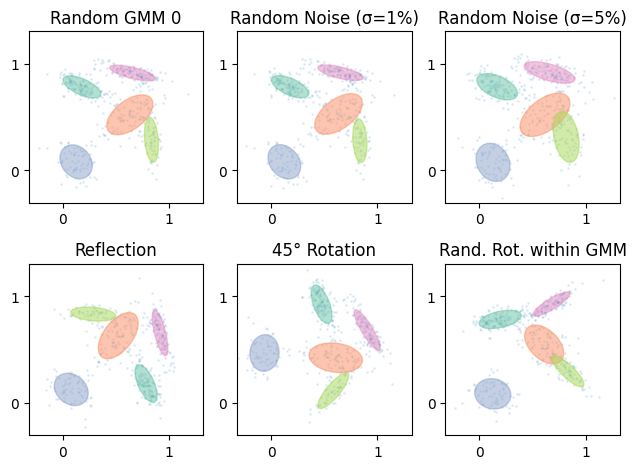

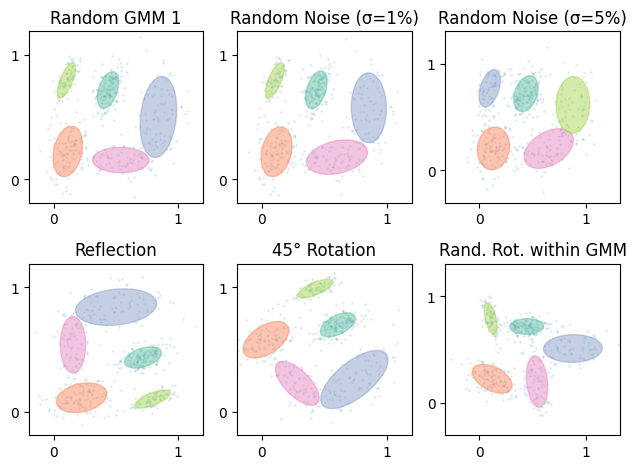

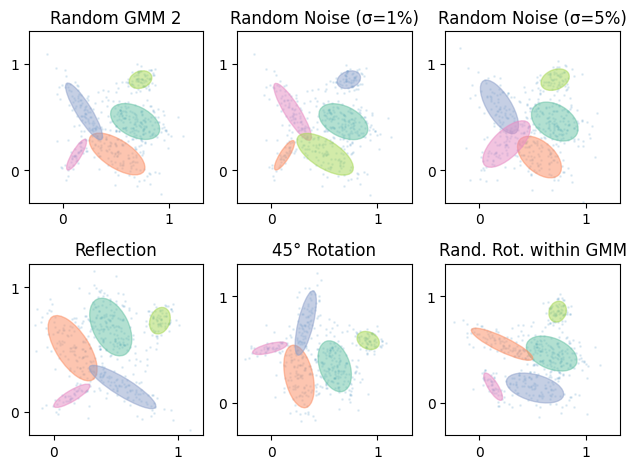

In [11]:
n=3
n_components = 5
GMMs = []
PTs = []

inner_dists = []
inner_dists_shape = []
labels = []

#noise parameter
mu, sigma = 0, 0.01 # mean and standard deviation


for i in range(n):
    fig, axs = plt.subplots(2,3)
    
    labels.append(f"Random GMM {i}")
    gmm, pts, true_components = random_GMM(n_components,title=labels[-1],ax=axs[0,0])
    GMMs.append(gmm)
    PTs.append(pts)
    inner_dists.append(inner_GMM__wasserstein_dist(gmm,pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(gmm,pts,shape_only=True))
    


    
    #test by putting noise on last GMM
    labels.append(f"Random Noise (σ=1%)")
    noisy_pts = np.copy(pts)
    for j,pt in enumerate(noisy_pts):
        xy_noise = np.random.normal(mu, 0.01, 2)
        noisy_pts[j] = pt + xy_noise

    GMMs.append(GaussianMixture(n_components=n_components, random_state=0).fit(noisy_pts))
    plot_ellipses(GMMs[-1],noisy_pts,title=labels[-1],ax=axs[0,1])
    inner_dists.append(inner_GMM__wasserstein_dist(GMMs[-1],noisy_pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(GMMs[-1],noisy_pts,shape_only=True))


    #test by putting noise on last GMM
    labels.append(f"Random Noise (σ=5%)")
    noisy_pts = np.copy(pts)
    for j,pt in enumerate(noisy_pts):
        xy_noise = np.random.normal(mu, 0.05, 2)
        noisy_pts[j] = pt + xy_noise

    GMMs.append(GaussianMixture(n_components=n_components, random_state=0).fit(noisy_pts))
    plot_ellipses(GMMs[-1],noisy_pts,title=labels[-1],ax=axs[0,2])
    inner_dists.append(inner_GMM__wasserstein_dist(GMMs[-1],noisy_pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(GMMs[-1],noisy_pts,shape_only=True))

    #test by reflecting last GMM
    labels.append(f"Reflection")
    swp_pts = np.copy(pts)[:,[1,0]]
    GMMs.append(GaussianMixture(n_components=n_components, random_state=0).fit(swp_pts))
    PTs.append(swp_pts)
    plot_ellipses(GMMs[-1],swp_pts,title=labels[-1],ax=axs[1,0])
    inner_dists.append(inner_GMM__wasserstein_dist(GMMs[-1],swp_pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(GMMs[-1],swp_pts,shape_only=True))

    #test by rotate points
    labels.append(f"45° Rotation")
    rot_pts = rotate(np.copy(pts),angle=-0.25*math.pi,origin = [0.5,0.5])
    GMMs.append(GaussianMixture(n_components=n_components, random_state=0).fit(rot_pts))
    PTs.append(rot_pts)
    plot_ellipses(GMMs[-1],rot_pts,title=labels[-1],ax=axs[1,1])
    inner_dists.append(inner_GMM__wasserstein_dist(GMMs[-1],rot_pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(GMMs[-1],rot_pts,shape_only=True))

    #test by rotate points of gaussian seperatly 
    labels.append(f"Rand. Rot. within GMM")
    rot_comp_pts = np.copy(pts)
    cmap = sns.color_palette(n_colors=10).as_hex()
    #print()
    #print(true_components)
    predicted_comps = gmm.predict(pts)
    for component in np.unique(predicted_comps):
        random_angle = np.random.rand()*2
        #print(gmm.means_[component])
        
        #axs[1,2].scatter(x=rot_comp_pts[predicted_comps == component][:,0],y=rot_comp_pts[predicted_comps == component][:,1],c=cmap[component],alpha=0.3,s=2)
        #axs[1,2].scatter(x=gmm.means_[component][0],y=gmm.means_[component][1],c=cmap[component],s=20)
        rot_comp_pts[predicted_comps == component] = rotate(rot_comp_pts[predicted_comps == component],angle=random_angle,origin=gmm.means_[component])
    #rot_pts = rotate(np.copy(pts),angle=-0.5*math.pi,origin = [0.5,0.5])
    GMMs.append(GaussianMixture(n_components=n_components, random_state=0).fit(rot_comp_pts))
    PTs.append(rot_comp_pts)
    plot_ellipses(GMMs[-1],rot_comp_pts,title=labels[-1],ax=axs[1,2])
    inner_dists.append(inner_GMM__wasserstein_dist(GMMs[-1],rot_comp_pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(GMMs[-1],rot_comp_pts,shape_only=True))

    #test by scale points
    '''
    labels.append(f"Scaling")
    scl_pts = np.copy(pts) * 1.5 -0.2
    GMMs.append(GaussianMixture(n_components=n_components, random_state=0).fit(scl_pts))
    PTs.append(scl_pts)
    plot_ellipses(GMMs[-1],scl_pts,title=labels[-1],ax=axs[1,2])
    inner_dists.append(inner_GMM__wasserstein_dist(GMMs[-1],scl_pts))
    inner_dists_shape.append(inner_GMM__wasserstein_dist(GMMs[-1],noisy_pts,shape_only=False))
    '''
    

    
    

    for ax in axs.flatten():
        ax.set_ylim(-0.2,1.2)
        ax.set_xlim(-0.2,1.2)
        ax.set_xticks((0,1))
        ax.set_yticks((0,1))
    plt.tight_layout()




<Axes: >

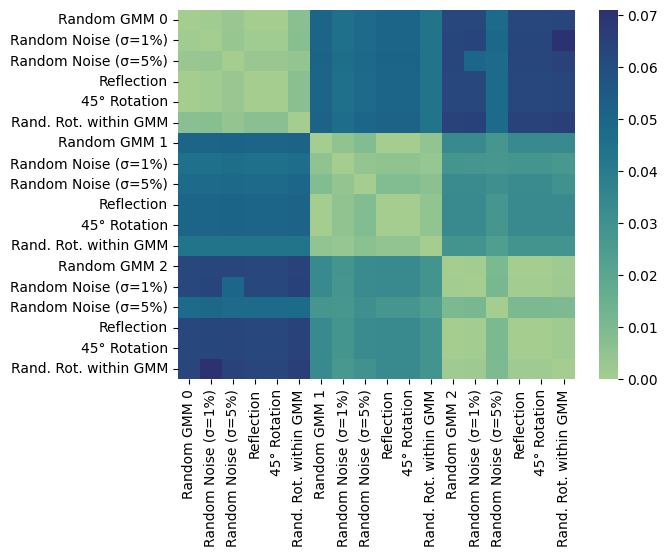

In [12]:
dist = np.zeros((len(GMMs),len(GMMs)))
for i,(dists1, gmm1) in enumerate(zip(inner_dists,GMMs)):
    for j,(dists2, gmm2) in enumerate(zip(inner_dists,GMMs)):
        w2, log = ot.gromov.gromov_wasserstein(
        C1=dists1, C2=dists2, p=gmm1.weights_, q=gmm2.weights_,loss_fun =  'square_loss', verbose=False, log=True)
        dist[i,j] = log['gw_dist']

sns.heatmap(dist,xticklabels=labels,yticklabels=labels,cmap="crest")

<Axes: >

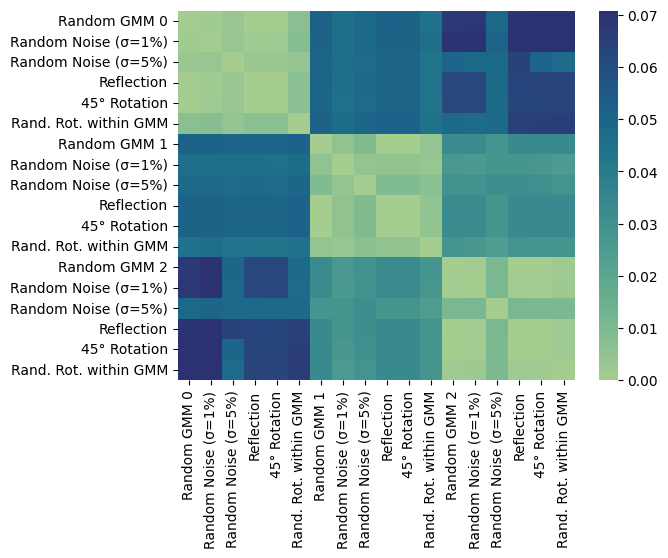

In [13]:
dist = np.zeros((len(GMMs),len(GMMs)))
for i,(dists1, gmm1) in enumerate(zip(inner_dists_shape,GMMs)):
    for j,(dists2, gmm2) in enumerate(zip(inner_dists_shape,GMMs)):
        w2, log = ot.gromov.gromov_wasserstein(
        C1=dists1, C2=dists2, p=gmm1.weights_, q=gmm2.weights_,loss_fun =  'square_loss', verbose=False, log=True)
        dist[i,j] = log['gw_dist']

sns.heatmap(dist,xticklabels=labels,yticklabels=labels,cmap="crest")

<Axes: >

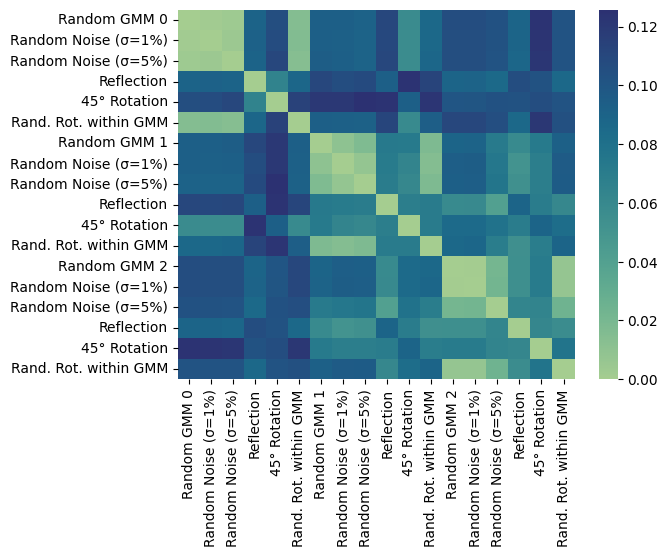

In [14]:
import lib

dist = np.zeros((len(GMMs),len(GMMs)))
for i,(dists1, gmm1) in enumerate(zip(inner_dists_shape,GMMs)):
    for j,(dists2, gmm2) in enumerate(zip(inner_dists_shape,GMMs)):
        dist[i,j] = lib.GMM_wasserstein_dist(gmm1,gmm2)

sns.heatmap(dist,xticklabels=labels, yticklabels=labels,cmap="crest")